In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-crime/test.csv.zip
/kaggle/input/sf-crime/sampleSubmission.csv.zip
/kaggle/input/sf-crime/train.csv.zip


In [2]:
pd.options.display.max_columns=None
pd.options.display.max_rows = None

The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set.
### Data fields
- Dates - timestamp of the crime incident 
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude <br>
Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each incident, you must submit a set of predicted probabilities (one for every class

In [3]:
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [6]:
train_data = pd.read_csv('../input/sf-crime/train.csv.zip')
#train_df = train_data.copy()
train_df = train_data.copy()

test_data = pd.read_csv('../input/sf-crime/test.csv.zip')
#test_df = test_data.copy()
test_df = test_data.copy()

sample_res = pd.read_csv('../input/sf-crime/sampleSubmission.csv.zip')
print(sample_res.shape) #39 categories
sample_res.head()

(884262, 40)


,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# EDA

In [7]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [9]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


# Data Pre-processing
## Drop 'Resolution' & 'Description' columns

In [11]:
#train_df.drop(['Resolution','Descript'], axis=1, inplace=True)
train_df2.drop(['Resolution','Descript'], axis=1, inplace=True)

In [12]:
train_df.tail()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


## Extract time and date from 'Dates' column

In [13]:
train_df2['Dates'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in train_df2["Dates"]]
test_df2['Dates'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in test_df2["Dates"]]

# extracting date from timestamp
#train_df2['Date'] = [datetime.datetime.date(d) for d in train_df2['Dates']] 
# extracting time from timestamp
#train_df2['Time'] = [datetime.datetime.time(d) for d in train_df2['Dates']] 

In [14]:
train_df2['Hour'] = [d.hour for d in train_df2['Dates']]
train_df2['Month'] = [d.month for d in train_df2['Dates']]

test_df2['Hour'] = [d.hour for d in test_df2['Dates']]
test_df2['Month'] = [d.month for d in test_df2['Dates']]

-------------------

In [15]:
#train_df2.drop(['Date','Time'],axis=1,inplace=True)
type(train_df2['Hour'][0])
train_df2['Hour'].unique()
train_df2['Hour'].value_counts()
train_df2.head()
train_df2['Month'].unique()
np.sort(train_df2['Category'].unique())

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

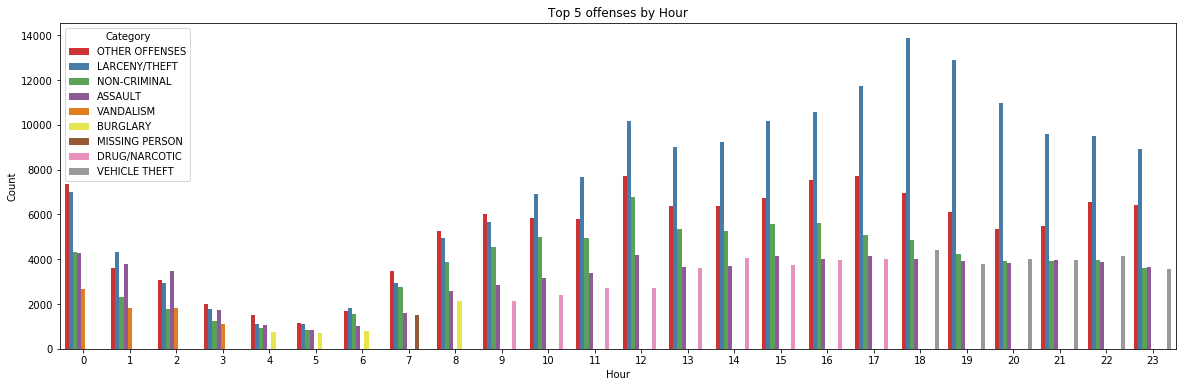

In [16]:
offenseByHour = pd.DataFrame(train_df2.groupby(['Hour','Category'])[['Category']].count())
offenseByHour.columns = ['Count']
offenseByHour.reset_index(inplace=True)
offenseByHour.sort_values(by=['Hour','Count'], ascending=False, inplace=True)
offenseByHour.head()

#Top 5 offenses by Hour
top5ByHour=pd.DataFrame()
for x in range(24):
    top5ByHour = top5ByHour.append(offenseByHour[offenseByHour['Hour']==x][:5])
#topTenOffensesbyYear = topTenOffensesbyYear.append(offensesByYearCatg[offensesByYearCatg['YEAR'] == years[x]][:10])

figure = plt.figure(figsize=(20,6))
sns.barplot(x=top5ByHour['Hour'], y=top5ByHour['Count'], hue=top5ByHour['Category'], palette='Set1')
#plt.legend(bbox_to_anchor=(1,1), loc='best', borderaxespad=1.1)
plt.title('Top 5 offenses by Hour')
#sns.despine()
plt.show()

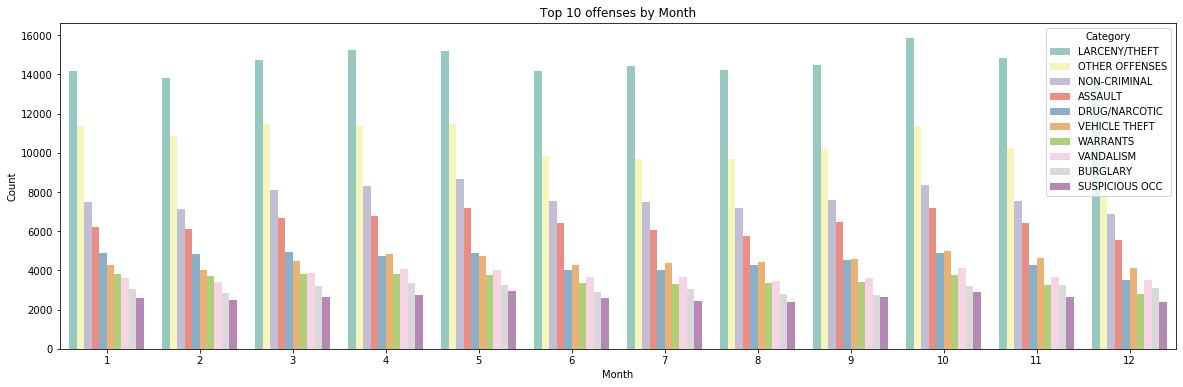

In [17]:
offenseByMonth = pd.DataFrame(train_df2.groupby(['Month','Category'])[['Category']].count())
offenseByMonth.columns = ['Count']
offenseByMonth.reset_index(inplace=True)
offenseByMonth.sort_values(by=['Month','Count'], ascending=False, inplace=True)
offenseByMonth.head()

#Top 5 offenses by Hour
top5ByMonth=pd.DataFrame()
for x in range(12):
    top5ByMonth = top5ByMonth.append(offenseByMonth[offenseByMonth['Month']==(x+1)][:10])
#topTenOffensesbyYear = topTenOffensesbyYear.append(offensesByYearCatg[offensesByYearCatg['YEAR'] == years[x]][:10])

figure = plt.figure(figsize=(20,6))
sns.barplot(x=top5ByMonth['Month'], y=top5ByMonth['Count'], hue=top5ByMonth['Category'], palette='Set3')
#plt.legend(bbox_to_anchor=(1,1), loc='best', borderaxespad=1.1)
plt.title('Top 10 offenses by Month')
#sns.despine()
plt.show()

In [19]:
categoryByMonth = pd.DataFrame(train_df2.groupby(['Category','Month'])[['Category']].count())
categoryByMonth.columns=['Count']
categoryByMonth.reset_index(inplace=True)
categoryByMonth.sort_values(by=['Category','Count'], ascending=False, inplace=True)
categoryByMonth.head()

categoryByHour = pd.DataFrame(train_df2.groupby(['Category','Hour'])[['Category']].count())
categoryByHour.columns=['Count']
categoryByHour.reset_index(inplace=True)
categoryByHour.sort_values(by=['Category','Count'], ascending=False, inplace=True)

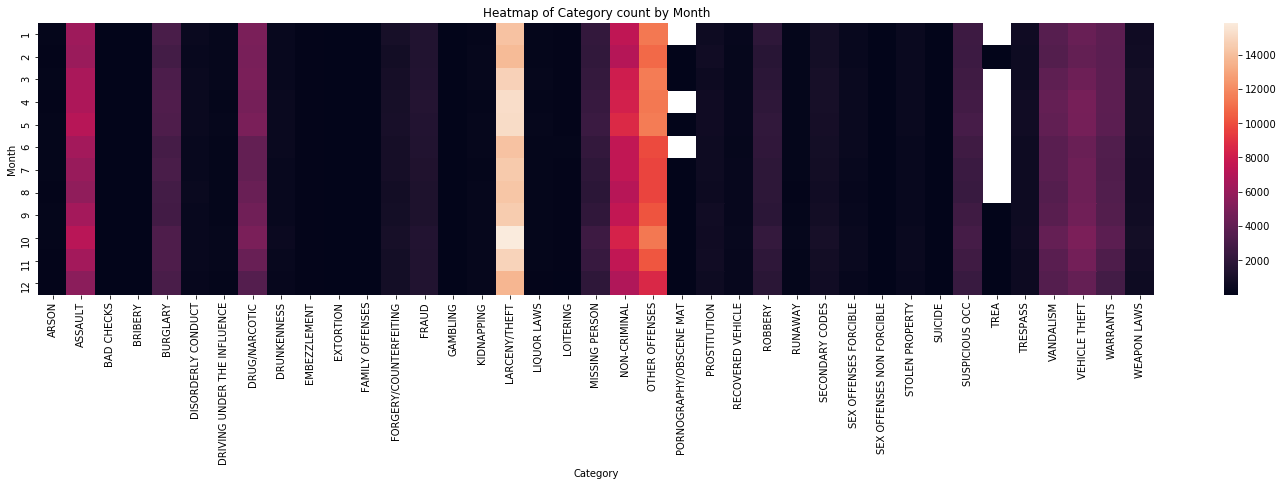

In [20]:
tmp1 = categoryByMonth.pivot('Month','Category','Count')
plt.figure(figsize=(25,5))
plt.title("Heatmap of Category count by Month")
sns.heatmap(data=tmp1)

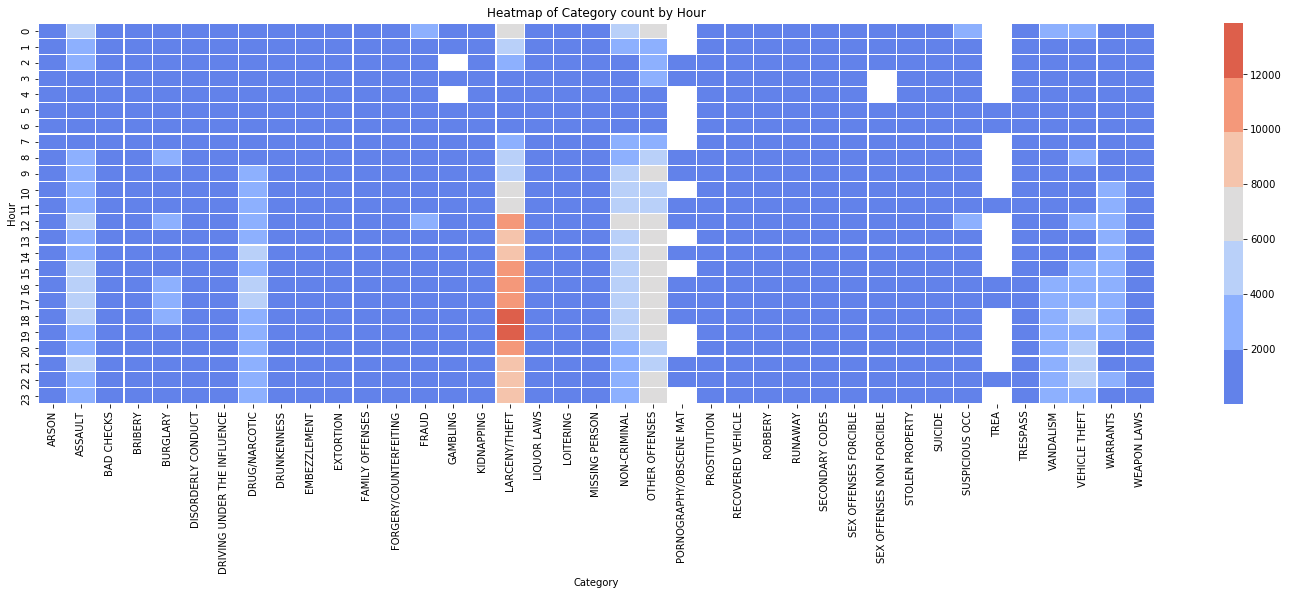

In [21]:
tmp2 = categoryByHour.pivot('Hour','Category','Count')
plt.figure(figsize=(25,7))
plt.title("Heatmap of Category count by Hour")
sns.heatmap(data=tmp2, linewidths=.1, cmap=sns.color_palette("coolwarm", 7)) # annot=True;BuGn_r;  GnBu_d

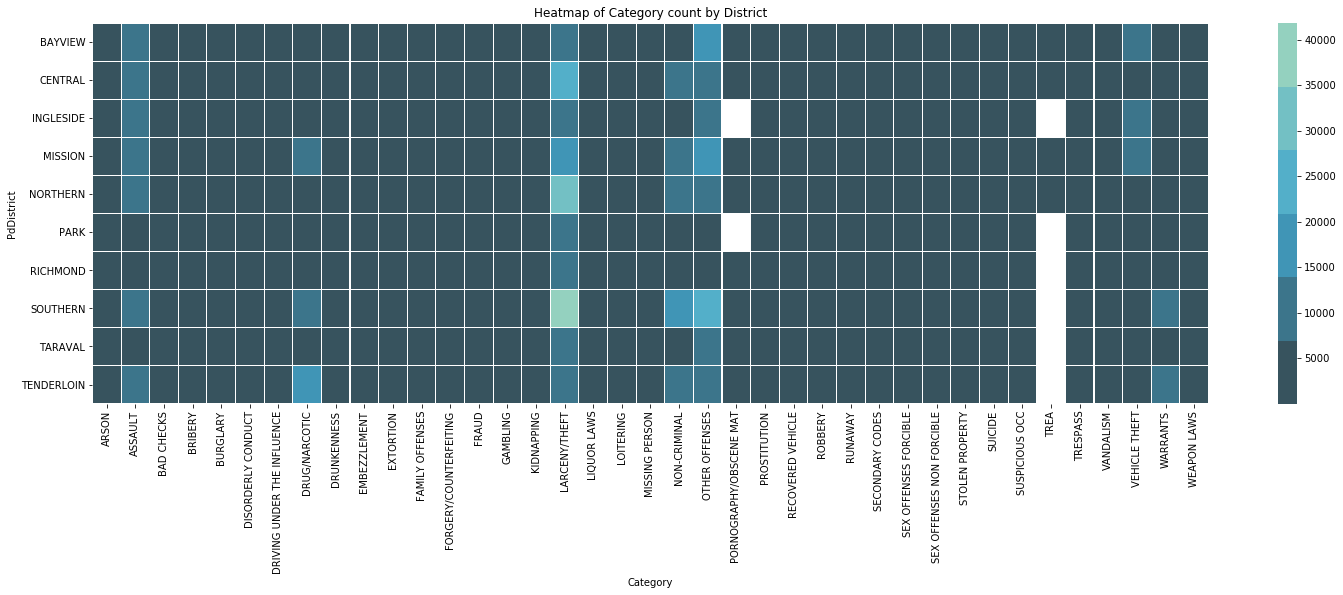

In [22]:
categoryByDistrict = pd.DataFrame(train_df2.groupby(['Category','PdDistrict'])[['Category']].count())
categoryByDistrict.columns=['Count']
categoryByDistrict.reset_index(inplace=True)
categoryByDistrict.sort_values(by=['PdDistrict','Count'], ascending=False, inplace=True)

tmp3 = categoryByDistrict.pivot("PdDistrict","Category","Count")
plt.figure(figsize=(25,7))
plt.title("Heatmap of Category count by District")
sns.heatmap(data=tmp3, linewidths=.1, cmap=sns.color_palette("GnBu_d"))

----------------------
### How to detect and classify seasonal crimes making use of datetime data??
- Seasonal: Summer(June-August); Autumn(Sept-Nov); Winter(Dec-Feb); Spring(March-May)
- Periods of day: Midnight(23-2), Dawn(3-6), Morning(7-10), Afternoon(11-14), Evening(15-18), Night(19-22)

In [23]:
def group_cols(df):
    seasons = []
    periods = []
    for key,value in df.iterrows():
        if ((value['Month']>=6) & (value['Month']<=8)):
            seasons.append('summer')
        elif ((value['Month']>=9)&(value['Month']<=11)):
            seasons.append('autumn')
        elif ((value['Month']==12)|(value['Month']<=2)):
            seasons.append('winter')
        else:
            seasons.append('spring')

        if ((value['Hour']==23)|(value['Hour']<=2)):
            periods.append('midnight')
        elif ((value['Hour']>=3)&(value['Hour']<=6)):
            periods.append('dawn')
        elif ((value['Hour']>=7)&(value['Hour']<=10)):
            periods.append('morning')
        elif ((value['Hour']>=11)&(value['Hour']<=14)):
            periods.append('noon')
        elif ((value['Hour']>=15)&(value['Hour']<=18)):
            periods.append('evening')
        else:
            periods.append('night')
    return seasons, periods

In [24]:
seasons, periods = group_cols(train_df2)
train_df2['Seasons'] = seasons
train_df2['DayPeriods'] = periods

seasons, periods = group_cols(test_df2)
test_df2['Seasons']= seasons
test_df2['DayPeriods']= periods

In [25]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>